# Import

In [ ]:
pip install pyvi nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, Embedding, Flatten, Conv2D, MaxPool2D, Bidirectional, LSTM, GRU, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.preprocessing import LabelEncoder

# Data is imbalanced
import nltk
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# PATH

In [ ]:
drive.mount('/content/drive/')
DIR_ROOT = '/content/drive/MyDrive/NLP/'
DIR_DATASET = os.path.join(DIR_ROOT, 'FakeCommentDetection/dataset/')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

MODEL_DIR = os.path.join(DIR_ROOT, 'model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Mounted at /content/drive/


# 1. Data Cleaning




In [ ]:
def preprocessing_data(PATH):
  df = pd.read_csv(PATH)

  # drop Rating, Spam -> focus on spam/ ham classification
  df = df.drop(['Rating','SpamLabel'], axis=1)

  # Encoder `Label` Column
  encoder=LabelEncoder()
  df.Label=encoder.fit_transform(df.Label)

  # check for empty comment
  # list row with empty comment
  lst_idx_emptyComement = df[df["Comment"] == "#NAME?"].index.tolist()
  df = df.drop(lst_idx_emptyComement)

  # check duplicate comment
  lst_idx_duplicates = df[df["Comment"].duplicated()].index.tolist()
  df = df.drop(lst_idx_duplicates)

  return df


In [ ]:
data_train = preprocessing_data(PATH_TRAIN)
data_dev = preprocessing_data(PATH_DEV)
data_test = preprocessing_data(PATH_TEST)

#  2. Exploratory Data Analysis (EDA)

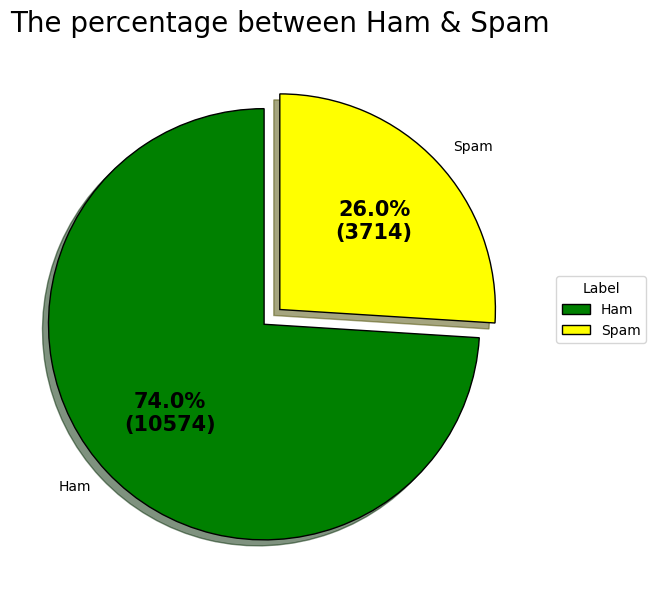

In [ ]:
# Đếm số lượng Ham và Spam của DATA_TRAIN
n_ham = data_train[data_train["Label"] == 0].shape[0]
n_spam = data_train[data_train["Label"] == 1].shape[0]
data = [n_ham, n_spam]


def percent_cal (pct, all_values):
    absolute = int(pct / 100.*np.sum(all_values))
    #f: %, d: sluong
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie (
                                  data,
                                  autopct = lambda pct: percent_cal(pct, data),
                                  explode = [.1, 0], # khoảng cách giữa Ham(Xanh) và Spam(Vàng)
                                  labels = ['Ham','Spam'],
                                  shadow = True,
                                  colors = ['green','yellow'],
                                  startangle = 90,
                                  wedgeprops = {'linewidth':1, 'edgecolor':'black'}, # viền
                                  textprops = dict(color ="black"))

# Adding legend
ax.legend(wedges,  ['Ham','Spam'],
          title ="Label",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 15, weight ="bold")
ax.set_title("The percentage between Ham & Spam",fontsize=20, loc='center')

# show plot
plt.show()

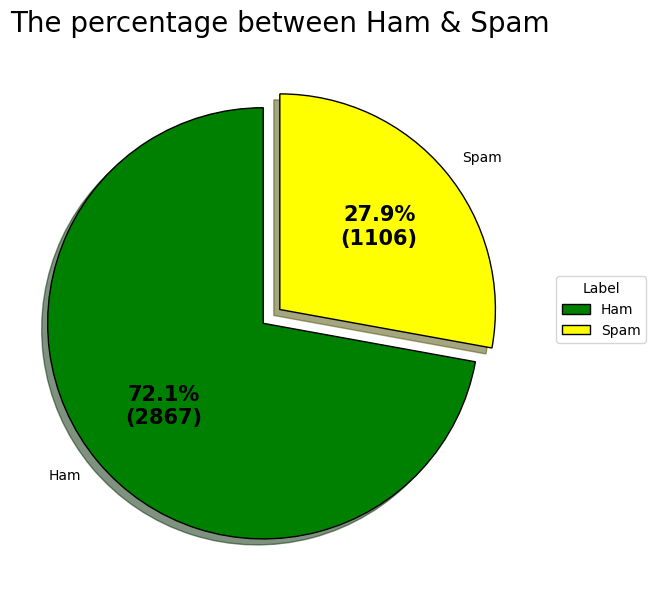

In [ ]:
# Đếm số lượng Ham và Spam của DATA_TEST
n_ham = data_test[data_test["Label"] == 0].shape[0]
n_spam = data_test[data_test["Label"] == 1].shape[0]
data = [n_ham, n_spam]


def percent_cal (pct, all_values):
    absolute = int(pct / 100.*np.sum(all_values))
    #f: %, d: sluong
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie (
                                  data,
                                  autopct = lambda pct: percent_cal(pct, data),
                                  explode = [.1, 0], # khoảng cách giữa Ham(Xanh) và Spam(Vàng)
                                  labels = ['Ham','Spam'],
                                  shadow = True,
                                  colors = ['green','yellow'],
                                  startangle = 90,
                                  wedgeprops = {'linewidth':1, 'edgecolor':'black'}, # viền
                                  textprops = dict(color ="black"))

# Adding legend
ax.legend(wedges,  ['Ham','Spam'],
          title ="Label",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 15, weight ="bold")
ax.set_title("The percentage between Ham & Spam",fontsize=20, loc='center')

# show plot
plt.show()

In [ ]:
# sl tu trong tu trong moi cmt
data_train['num_characters']=data_train.Comment.apply(len)

# word count of each comment
data_train['num_words']=data_train.Comment.apply(lambda x:len(nltk.word_tokenize(x)))

In [ ]:
# word count of each comment
data_train['num_words']=data_train.Comment.apply(lambda x:len(nltk.word_tokenize(x)))

In [ ]:
# return the numbers of sentences in each comment
data_train['num_sentences']=data_train.Comment.apply(lambda x:len(nltk.sent_tokenize(x)))

In [ ]:
data_train.head()

,Comment,Label,num_characters,num_words,num_sentences
0,"Chất lượng sản phẩm tuyệt vời, má",0,33,8,1
1,Jdjd is a waste of my time and place to ask qu...,1,174,31,1
2,Dhnxncbcncncncncnncncncnncncncncncncncnncncncj...,1,50,1,1
3,"giao hàng nhanh, đóng gói cẩn thận, sản phẩm n...",0,61,16,1
4,Bạt mỏng vs lại không có túi đi kèm để cất khi...,0,92,24,2


In [ ]:
#Label == 0 || Label== 1
data_train[['num_characters','num_words','num_sentences']].describe()


,num_characters,num_words,num_sentences
count,14290.000000,14290.000000,14290.000000
mean,121.803359,29.112526,1.986214
std,95.163744,24.317946,1.453463
min,1.000000,1.000000,1.000000
25%,63.000000,14.000000,1.000000
50%,92.000000,22.000000,1.000000
75%,156.000000,38.000000,3.000000
max,1084.000000,216.000000,19.000000


In [ ]:
# Label == 0 (ham)
data_train[data_train.Label==0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,10575.000000,10575.000000,10575.000000
mean,120.240851,30.260898,2.068463
std,94.127422,23.705915,1.471706
min,4.000000,1.000000,1.000000
25%,64.000000,16.000000,1.000000
50%,92.000000,23.000000,1.000000
75%,151.000000,38.000000,3.000000
max,617.000000,163.000000,14.000000


In [ ]:
# Label == 1 (spam)
data_train[data_train.Label==1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,3715.000000,3715.000000,3715.000000
mean,126.251144,25.843607,1.752086
std,97.930259,25.705239,1.373716
min,1.000000,1.000000,1.000000
25%,60.000000,6.000000,1.000000
50%,91.000000,17.000000,1.000000
75%,178.000000,37.000000,2.000000
max,1084.000000,216.000000,19.000000


<Axes: xlabel='num_characters', ylabel='Count'>

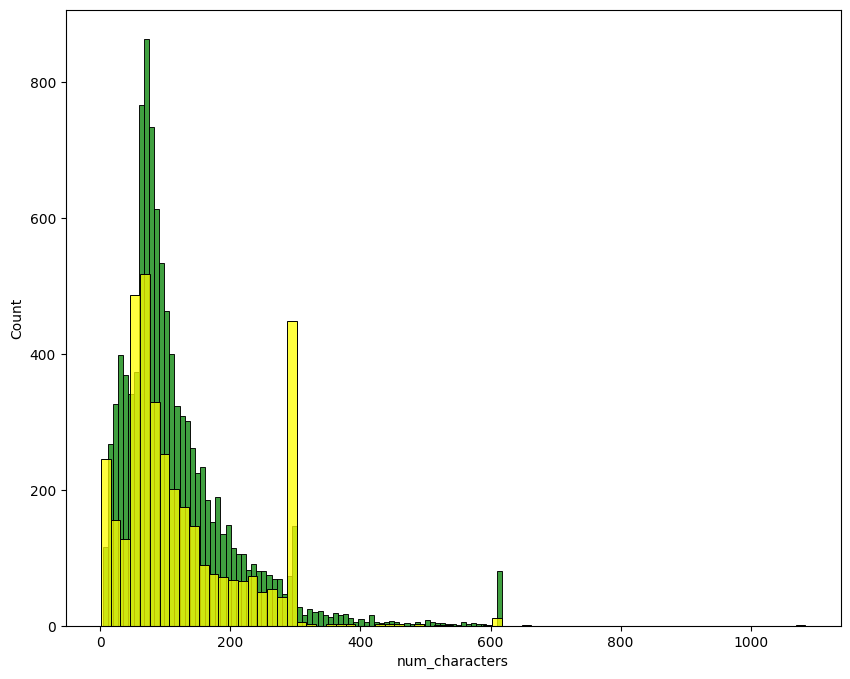

In [ ]:
plt.figure(figsize=(10,8))
# 0
sn.histplot (data_train[data_train.Label==0]['num_characters'], color='green')
# 1
sn.histplot (data_train[data_train.Label==1]['num_characters'], color='yellow')

<Axes: xlabel='num_words', ylabel='Count'>

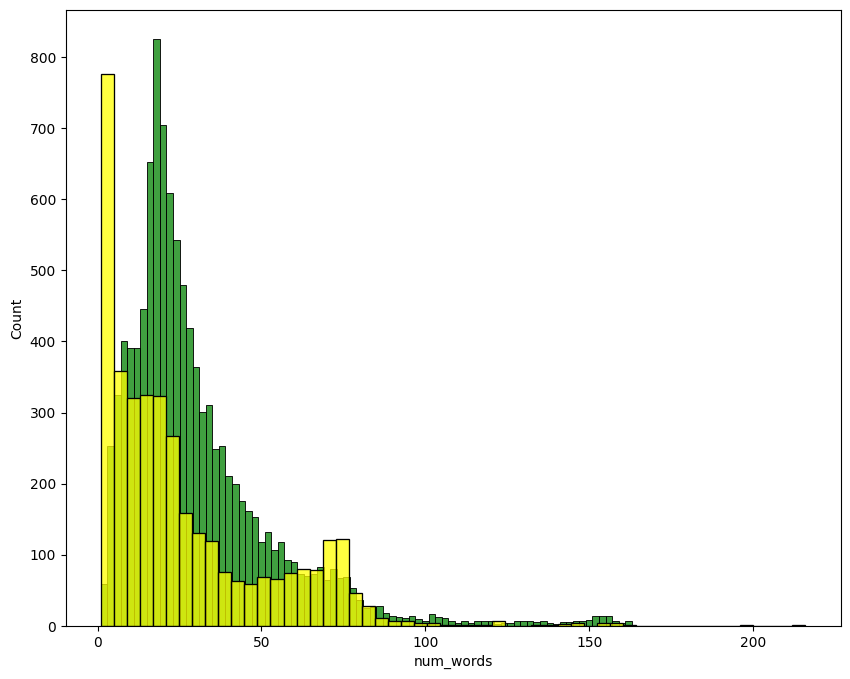

In [ ]:
plt.figure(figsize=(10,8))
# 0
sn.histplot (data_train[data_train.Label==0]['num_words'], color='green')
# 1
sn.histplot (data_train[data_train.Label==1]['num_words'], color='yellow')

<Axes: xlabel='num_sentences', ylabel='Count'>

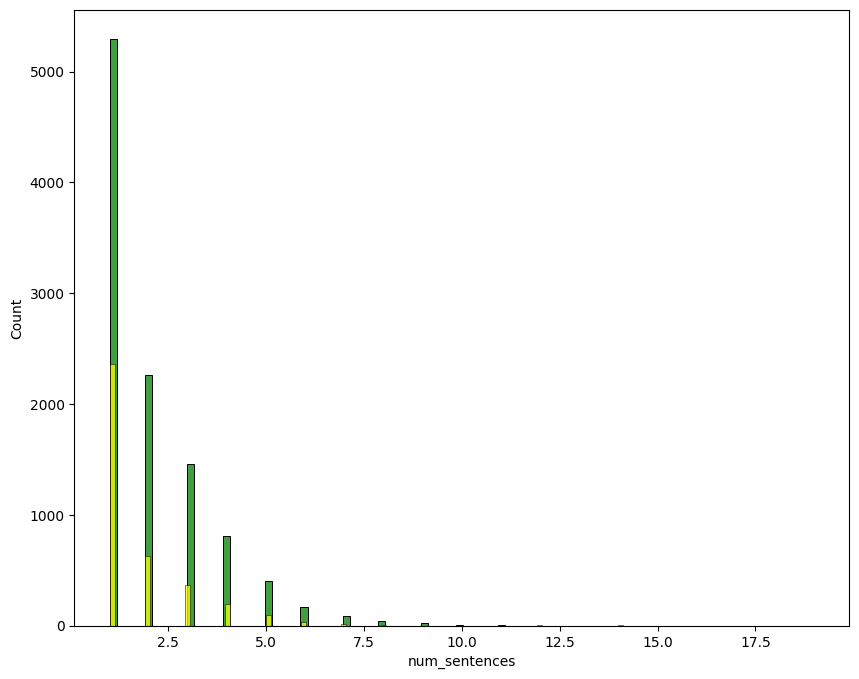

In [ ]:
plt.figure(figsize=(10,8))
# 0
sn.histplot (data_train[data_train.Label==0]['num_sentences'], color='green')
# 1
sn.histplot (data_train[data_train.Label==1]['num_sentences'], color='yellow')

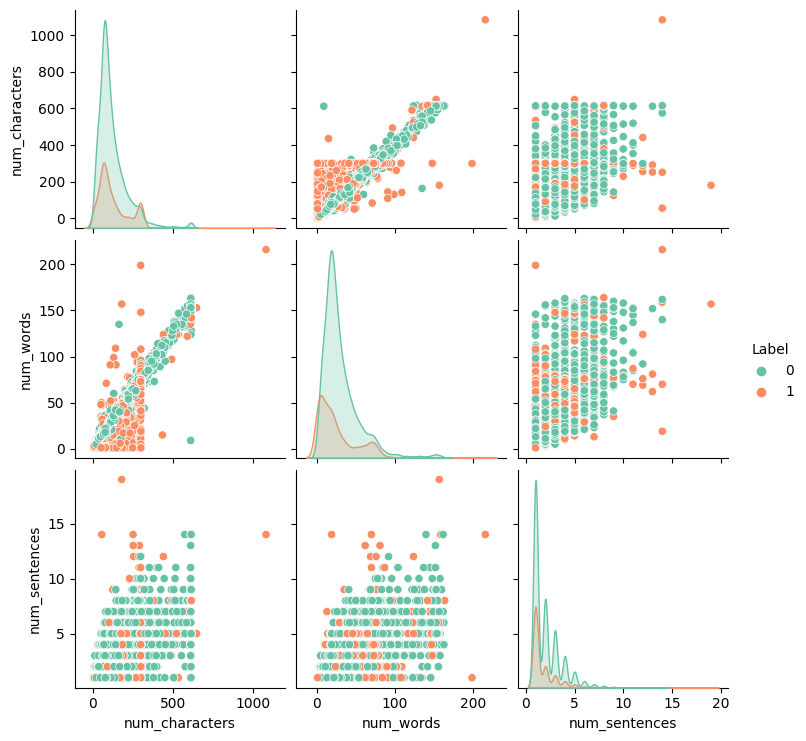

In [ ]:
sn.pairplot (data_train, hue='Label', palette='Set2')

<Axes: >

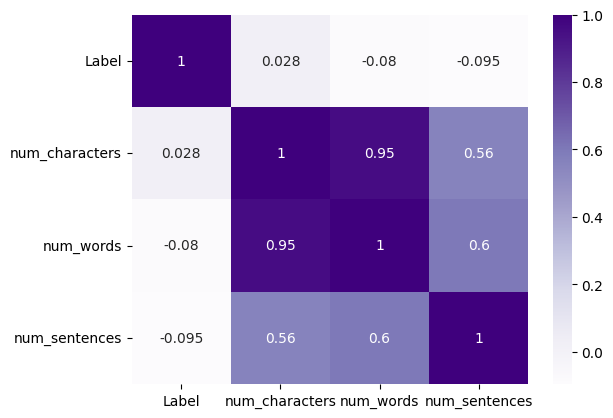

In [ ]:
sn.heatmap(data_train.corr(), annot=True, cmap='Purples')

#  3. Data Preprocessing





*   Lower case

*   Tokenzation

*   Removing special characters

*   Removing stopwords and punctuation

*   Stemming / Lemmatization

## Tokenization + slowercase + remove stop words + punctuation

Những từ 2 âm tiết như `hiệu quả`, và `chất lượng` -> `hiệu_quả` và `chất lượng` để giữ nguyên ý nghĩa của từ

In [ ]:
data_train["Comment"] = data_train["Comment"].apply(ViTokenizer.tokenize)
data_train.head()

,Comment,Label,num_characters,num_words,num_sentences
0,"Chất_lượng sản_phẩm tuyệt_vời , má",0,33,8,1
1,Jdjd is a waste of my time and place to ask qu...,1,174,31,1
2,Dhnxncbcncncncncnncncncnncncncncncncncnncncncj...,1,50,1,1
3,"giao hàng nhanh , đóng_gói cẩn_thận , sản_phẩm...",0,61,16,1
4,Bạt mỏng vs lại không có túi đi kèm để cất khi...,0,92,24,2


In [ ]:
def get_stopwords_list(stop_file_path):
    """load stop words """

    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip().replace(" ", "_") for m in stopwords)
        return list(frozenset(stop_set))


stopwords_path = DIR_ROOT +"FakeCommentDetection/vietnamese-stopwords-dash.txt"
stopwords = get_stopwords_list(stopwords_path)
stopwords[:10]

['cao_sang',
 'tênh',
 'vì_chưng',
 'bỏ_việc',
 'nếu_mà',
 'hay',
 'cùng_ăn',
 'khác_khác',
 'tính_căn',
 'đáo_để']

In [ ]:
def transform_text(message):
    message = ViTokenizer.tokenize(message)

    # Remove punctuations
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again
    nopunc = "".join(nopunc)
    nopunc = nopunc.lower()

    # Remove any stopwords and non-alphabetic characters
    nostop = [
        word
        for word in nopunc.split()
        if word.lower() not in stopwords and word.isalpha()
    ]

    # Nối list từ lại thành chuỗi
    return ' '.join(nostop)

In [ ]:
data_train['transformed_text']=data_train['Comment'].apply(transform_text)
data_dev['transformed_text']=data_dev['Comment'].apply(transform_text)
data_test['transformed_text']=data_test['Comment'].apply(transform_text)

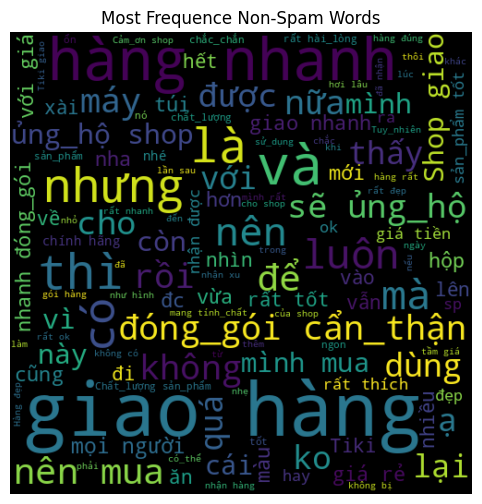

In [ ]:
# Occurrence frequency of NON-SPAM WORDS
ham=" ".join(data_train[data_train.Label==0]['Comment'])
from wordcloud import WordCloud
wc=WordCloud(width=500, height=500, min_font_size=10,max_words=200, background_color='black').generate(ham)

# plot
plt.figure (figsize=(10,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequence Non-Spam Words')
plt.show()

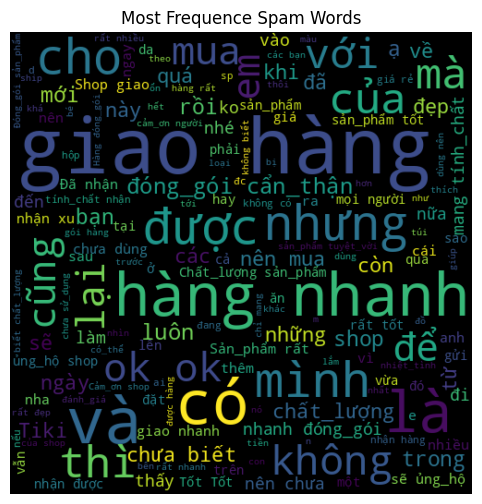

In [ ]:
# Occurrence frequency của SPAM WORDS
spam=" ".join(data_train[data_train.Label==1]['Comment'])
from wordcloud import WordCloud
wc=WordCloud(width=500, height=500, min_font_size=10,max_words=200, background_color='black').generate(spam)

#plot
plt.figure (figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequence Spam Words')
plt.show()

In [ ]:
spam_corpus=[]
for msg in data_train[data_train.Label==1]['transformed_text'].tolist():
  for word in msg.split():
    spam_corpus.append(word)

In [ ]:
spam_corpus_processed=[transform_text(text) for text in spam_corpus]

## Drop ""


Emotion text is ignored and transformed into '   '

#### replace emotion

In [ ]:
def replace_emotion(df):
  df['transformed_text'].replace('', np.nan,inplace=True)
  df.dropna(subset=['transformed_text'],inplace=True)
  return df


In [ ]:
data_train = replace_emotion(data_train)
data_dev = replace_emotion(data_dev)
data_test = replace_emotion(data_test)
data_train.head()

,Comment,Label,num_characters,num_words,num_sentences,transformed_text
0,"Chất_lượng sản_phẩm tuyệt_vời , má",0,33,8,1,chấtlượng sảnphẩm tuyệtvời má
1,Jdjd is a waste of my time and place to ask qu...,1,174,31,1,jdjd is a waste of my time and place to ask qu...
2,Dhnxncbcncncncncnncncncnncncncncncncncnncncncj...,1,50,1,1,dhnxncbcncncncncnncncncnncncncncncncncnncncncj...
3,"giao hàng nhanh , đóng_gói cẩn_thận , sản_phẩm...",0,61,16,1,giao hàng đónggói cẩnthận sảnphẩm nóichung ok
4,Bạt mỏng vs lại không có túi đi kèm để cất khi...,0,92,24,2,bạt mỏng vs túi đi kèm cất tạm phùhợp vs gía tiền


## save clean_data into files

In [ ]:
data_train.to_excel(DIR_ROOT +"FakeCommentDetection/transformed_dataset/clean_data/data_train.xlsx")
data_dev.to_excel(DIR_ROOT + "FakeCommentDetection/transformed_dataset/clean_data/data_dev.xlsx")
data_test.to_excel(DIR_ROOT +"FakeCommentDetection/transformed_dataset/clean_data/data_test.xlsx")